*Accompanying code examples of the book "Introduction to Artificial Neural Networks and Deep Learning: A Practical Guide with Applications in Python" by [Sebastian Raschka](https://sebastianraschka.com). All code examples are released under the [MIT license](https://github.com/rasbt/deep-learning-book/blob/master/LICENSE). If you find this content useful, please consider supporting the work by buying a [copy of the book](https://leanpub.com/ann-and-deeplearning).*
  
Other code examples and content are available on [GitHub](https://github.com/rasbt/deep-learning-book). The PDF and ebook versions of the book are available through [Leanpub](https://leanpub.com/ann-and-deeplearning).

In [1]:
#load watermark
%load_ext watermark
%watermark -a 'Gopala KR' -u -d -v -p watermark,numpy,matplotlib,nltk,sklearn,tensorflow,theano,mxnet,chainer,seaborn,keras,tflearn,bokeh,gensim

/srv/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Using TensorFlow backend.
/srv/venv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Gopala KR 
last updated: 2018-02-28 

CPython 3.6.3
IPython 6.2.1

watermark 1.6.0
numpy 1.14.1
matplotlib 2.1.2
nltk 3.2.5
sklearn 0.19.1
tensorflow 1.5.0
theano 1.0.1
mxnet 1.1.0
chainer 3.4.0
seaborn 0.8.1
keras 2.1.4
tflearn n
bokeh 0.12.14
gensim 3.3.0


/srv/venv/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


# Model Zoo -- Autoencoder

A simple, single-layer autoencoder that compresses 768-pixel MNIST images into 32-pixel vectors (32-times smaller representations).

In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

##########################
### WRAPPER FUNCTIONS
##########################

def fully_connected(input_tensor, output_nodes,
                    activation=None, seed=None,
                    name='fully_connected'):

    with tf.name_scope(name):
        input_nodes = input_tensor.get_shape().as_list()[1]
        weights = tf.Variable(tf.truncated_normal(shape=(input_nodes,
                                                         output_nodes),
                                                  mean=0.0,
                                                  stddev=0.1,
                                                  dtype=tf.float32,
                                                  seed=seed),
                              name='weights')
        biases = tf.Variable(tf.zeros(shape=[output_nodes]), name='biases')

        act = tf.matmul(input_tensor, weights) + biases
        if activation is not None:
            act = activation(act)
        return act


##########################
### DATASET
##########################

mnist = input_data.read_data_sets("./", validation_size=0)


##########################
### SETTINGS
##########################


# Hyperparameters
learning_rate = 0.01
training_epochs = 5
batch_size = 128

# Architecture
hidden_size = 32
input_size = 784
image_width = 28

# Other
print_interval = 200
random_seed = 123


##########################
### GRAPH DEFINITION
##########################

g = tf.Graph()
with g.as_default():
    
    tf.set_random_seed(random_seed)

    # Input data
    input_layer = tf.placeholder(tf.float32, [None, input_size],
                                 name='input')

    ###########
    # Encoder
    ###########
    
    hidden_layer = fully_connected(input_layer, hidden_size, 
                                   activation=tf.nn.relu, 
                                   name='encoding')
    
    ###########
    # Decoder
    ###########
    
    logits = fully_connected(hidden_layer, input_size, 
                             activation=None, name='logits')
    # note MNIST pixels are normalized to 0-1 range
    out_layer = tf.nn.sigmoid(logits, name='decoding') 
    
    ##################
    # Loss & Optimizer
    ##################
    
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        labels=input_layer, logits=logits), name='cost')
    
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train = optimizer.minimize(cost, name='train')

    # Saver to save session for reuse
    saver = tf.train.Saver()

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


/srv/venv/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:539: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/srv/venv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


In [3]:
import numpy as np

##########################
### TRAINING & EVALUATION
##########################
    
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())

    np.random.seed(random_seed) # random seed for mnist iterator
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = mnist.train.num_examples // batch_size


        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            _, c = sess.run(['train', 'cost:0'], 
                            feed_dict={'input:0': batch_x})
            avg_cost += c
            
            if not i % print_interval:
                print("Minibatch: %03d | Cost:    %.3f" % (i + 1, c))
    
        print("Epoch:     %03d | AvgCost: %.3f" % (epoch + 1, avg_cost / (i + 1)))
    
    saver.save(sess, save_path='./autoencoder.ckpt')

Minibatch: 001 | Cost:    0.702
Minibatch: 201 | Cost:    0.124
Minibatch: 401 | Cost:    0.111
Epoch:     001 | AvgCost: 0.144
Minibatch: 001 | Cost:    0.110
Minibatch: 201 | Cost:    0.107
Minibatch: 401 | Cost:    0.113
Epoch:     002 | AvgCost: 0.108
Minibatch: 001 | Cost:    0.108
Minibatch: 201 | Cost:    0.108
Minibatch: 401 | Cost:    0.112
Epoch:     003 | AvgCost: 0.107
Minibatch: 001 | Cost:    0.105
Minibatch: 201 | Cost:    0.101
Minibatch: 401 | Cost:    0.110
Epoch:     004 | AvgCost: 0.107
Minibatch: 001 | Cost:    0.101
Minibatch: 201 | Cost:    0.106
Minibatch: 401 | Cost:    0.106
Epoch:     005 | AvgCost: 0.107


INFO:tensorflow:Restoring parameters from ./autoencoder.ckpt


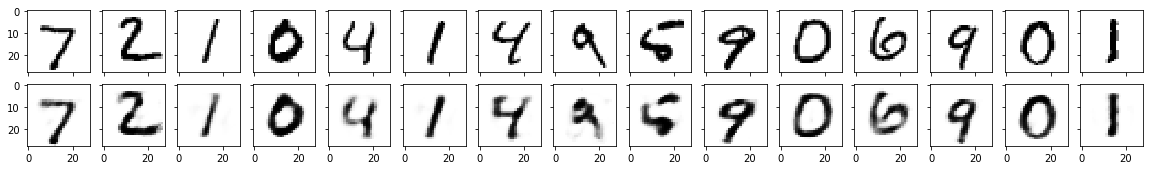

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

##########################
### VISUALIZATION
##########################

n_images = 15

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
test_images = mnist.test.images[:n_images]

with tf.Session(graph=g) as sess:
    saver.restore(sess, save_path='./autoencoder.ckpt')
    decoded = sess.run('decoding:0', feed_dict={'input:0': test_images})

for i in range(n_images):
    for ax, img in zip(axes, [test_images, decoded]):
        ax[i].imshow(img[i].reshape((image_width, image_width)), cmap='binary')
